In [1]:
 ## 0 · Imports & Configuration

import warnings
warnings.filterwarnings("ignore")

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Fairlearn for multi-slice metric comparison
try:
    from fairlearn.metrics import MetricFrame, count, selection_rate
    HAS_FAIRLEARN = True
    print("✓ Fairlearn available")
except ImportError:
    HAS_FAIRLEARN = False
    print("Fairlearn not installed – run: pip install fairlearn")

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

RESOURCE_ID = "42c33f05-2572-404e-9782-38d755f0f069"
BASE_URL    = "https://data.boston.gov/api/3/action/datastore_search"
BATCH_SIZE  = 10_000

print("Ready.")

✓ Fairlearn available
Ready.


In [2]:
#  ## 1 · Data Ingestion

def fetch_all_records(resource_id: str, batch_size: int = 10_000) -> pd.DataFrame:
    """Paginate through CKAN DataStore and return all records as a DataFrame."""
    all_records, offset = [], 0
    params = {"resource_id": resource_id, "limit": batch_size, "offset": 0}

    resp = requests.get(BASE_URL, params=params, timeout=60)
    resp.raise_for_status()
    data = resp.json()
    if not data.get("success"):
        raise RuntimeError(f"API error: {data.get('error')}")

    result = data["result"]
    total  = result["total"]
    print(f"Total records: {total:,}")
    all_records.extend(result["records"])
    offset += batch_size

    while offset < total:
        params["offset"] = offset
        batch = requests.get(BASE_URL, params=params, timeout=60).json()["result"]["records"]
        all_records.extend(batch)
        offset += batch_size
        print(f"  Fetched {min(offset, total):,}/{total:,}", end="\r")

    print(f"\nLoaded {len(all_records):,} records.")
    return pd.DataFrame(all_records)


df_raw = fetch_all_records(RESOURCE_ID, BATCH_SIZE)
df_raw.head(5)


Total records: 514

Loaded 514 records.


,_id,globalid,CreationDate,Creator,EditDate,Editor,date_and_time,your_mode_of_transportation,mode_other,request,request_other,additional_comments,shape_wkt,POINT_X,POINT_Y
0,1,{92C0E459-BF64-4E99-92B7-D4FF8882BFB1},6/14/2022 19:39:23.797,None,6/14/2022 19:39:23.797,None,6/14/2022 19:38:00.000,walks,None,speeding,None,None,POINT (-71.088253122999959 42.322298380000063),-71.088253122999959,42.322298380000063
1,2,{BC4B9871-3770-497D-A9D0-1C6FC730442E},6/15/2022 22:05:31.837,None,6/15/2022 22:05:31.837,None,6/15/2022 22:03:00.000,walks,None,runlightssigns,None,"During rush hour, eastbound traffic on Herald ...",POINT (-71.063180441999975 42.346246486000041),-71.063180441999975,42.346246486000041
2,3,{2B391665-C465-455E-B30F-699BC45B747E},6/15/2022 22:07:40.199,None,6/15/2022 22:07:40.199,None,6/15/2022 22:06:00.000,walks,None,yieldgoing,None,Traffic on Day Blvd does not consistently yiel...,POINT (-71.046808238999972 42.32894579200007),-71.046808238999972,42.328945792000070
3,4,{725960F2-127E-4158-8F12-5FE14EC38B29},6/23/2022 14:31:12.307,168240_boston,6/23/2022 14:31:12.307,168240_boston,6/23/2022 14:30:00.000,drives,None,yieldgoing,None,Trying to turn left to the highway when leavin...,POINT (-71.058379287999969 42.364719622000052),-71.058379287999969,42.364719622000052
4,5,{F450AA35-9683-43D6-983D-F7538B588097},6/27/2022 20:11:07.529,None,6/27/2022 20:11:07.529,None,6/27/2022 20:09:00.000,drives,None,other,The traffic pattern was changed but the “right...,None,POINT (-71.098068836999971 42.315684731000033),-71.098068836999971,42.315684731000033


In [3]:
# ── Type coercions & feature engineering ─────────────────────────────────────
df = df_raw.copy()

# ── Datetime ─────────────────────────────────────────────────────────────────
df["date_and_time"] = pd.to_datetime(df["date_and_time"], errors="coerce")
df["YEAR"]          = df["date_and_time"].dt.year
df["MONTH"]         = df["date_and_time"].dt.month
df["HOUR"]          = df["date_and_time"].dt.hour
df["DAY_OF_WEEK"]   = df["date_and_time"].dt.day_name()
df["DAY_OF_WEEK"]   = df["DAY_OF_WEEK"].astype(str).str.strip().str.title()

# ── Coordinates ───────────────────────────────────────────────────────────────
for col in ["POINT_X", "POINT_Y"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
# Drop (0, 0) placeholders
df.loc[(df["POINT_X"] == 0) | (df["POINT_Y"] == 0), ["POINT_X", "POINT_Y"]] = np.nan

# ── Mode of transportation – clean up ────────────────────────────────────────
df["mode"] = (
    df["your_mode_of_transportation"]
    .astype(str).str.strip().str.lower()
    .replace("none", np.nan)
    .replace("nan",  np.nan)
)
# Map free-text "mode_other" back when mode is missing / "other"
mask_other = df["mode"].isin(["other", np.nan]) & df["mode_other"].notna()
df.loc[mask_other, "mode"] = "other: " + df.loc[mask_other, "mode_other"].str.strip().str.lower()

# ── Request types – multi-valued column → explode ────────────────────────────
# Raw values look like: "speeding", "runlights,signs", "yield,going"
df["request_clean"] = (
    df["request"]
    .astype(str).str.strip().str.lower()
    .replace("none", np.nan).replace("nan", np.nan)
)
# Exploded version: one row per (record, request_type) for distribution analysis
df_req = (
    df.dropna(subset=["request_clean"])
      .assign(request_type=lambda d: d["request_clean"].str.split(","))
      .explode("request_type")
)
df_req["request_type"] = df_req["request_type"].str.strip()

# ── Vulnerable road-user flag ────────────────────────────────────────────────
VULN_MODES = {"walks", "bikes"}
df["IS_VULN"] = df["mode"].isin(VULN_MODES).astype(int)

# ── Time of day ───────────────────────────────────────────────────────────────
df["TIME_OF_DAY"] = pd.cut(
    df["HOUR"],
    bins=[-1, 5, 11, 17, 23],
    labels=["Night (0-5)", "Morning (6-11)", "Afternoon (12-17)", "Evening (18-23)"]
)

print("Shape:", df.shape)
df.dtypes

Shape: (514, 23)


_id                                     int64
globalid                               object
CreationDate                           object
Creator                                object
EditDate                               object
Editor                                 object
date_and_time                  datetime64[ns]
your_mode_of_transportation            object
mode_other                             object
request                                object
request_other                          object
additional_comments                    object
shape_wkt                              object
POINT_X                               float64
POINT_Y                               float64
YEAR                                    int32
MONTH                                   int32
HOUR                                    int32
DAY_OF_WEEK                            object
mode                                   object
request_clean                          object
IS_VULN                           

In [4]:
# ---
# ## 2 · Exploratory Data Analysis

# ### 2.1 Dataset Overview

print("=" * 60)
print(f"Rows  : {df.shape[0]:,}")
print(f"Cols  : {df.shape[1]}")
print(f"Date range : {df['date_and_time'].min()}  →  {df['date_and_time'].max()}")
print("=" * 60)

missing     = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
overview    = pd.DataFrame({"Missing": missing, "Missing %": missing_pct})
overview    = overview[overview["Missing"] > 0].sort_values("Missing %", ascending=False)
print("\nColumns with missing values:")
display(overview)

Rows  : 514
Cols  : 23
Date range : 2022-06-14 19:38:00  →  2026-02-14 13:11:00

Columns with missing values:


,Missing,Missing %
Creator,510,99.22
Editor,510,99.22
mode_other,501,97.47
request_other,443,86.19
additional_comments,57,11.09


 Mode of Transportation:
   walks                             261
   bikes                             164
   drives                             76
   other: walk/bike                    2
   other: have experienced this st on multiple modes since i was little      1
   other: sitting on my porch watching them drive by speeding      1
   other: walks/bikes                  1
   other: i've seen this occur on a daily basis while walking and driving..      1
   other: bike/walk                    1
   other: from being a local resident      1
   other: on the 66 bus                1
   other: at home                      1
   other: walking and driving          1
   other: i live 3 stops from stop sign and witness drive through stop sign at excessive speed every single day.      1
   other: i have lived at this intersection for 4 years      1

 Request Types (exploded):
   bikefacility             88
   other                    75
   speeding                 69
   runlightssigns         

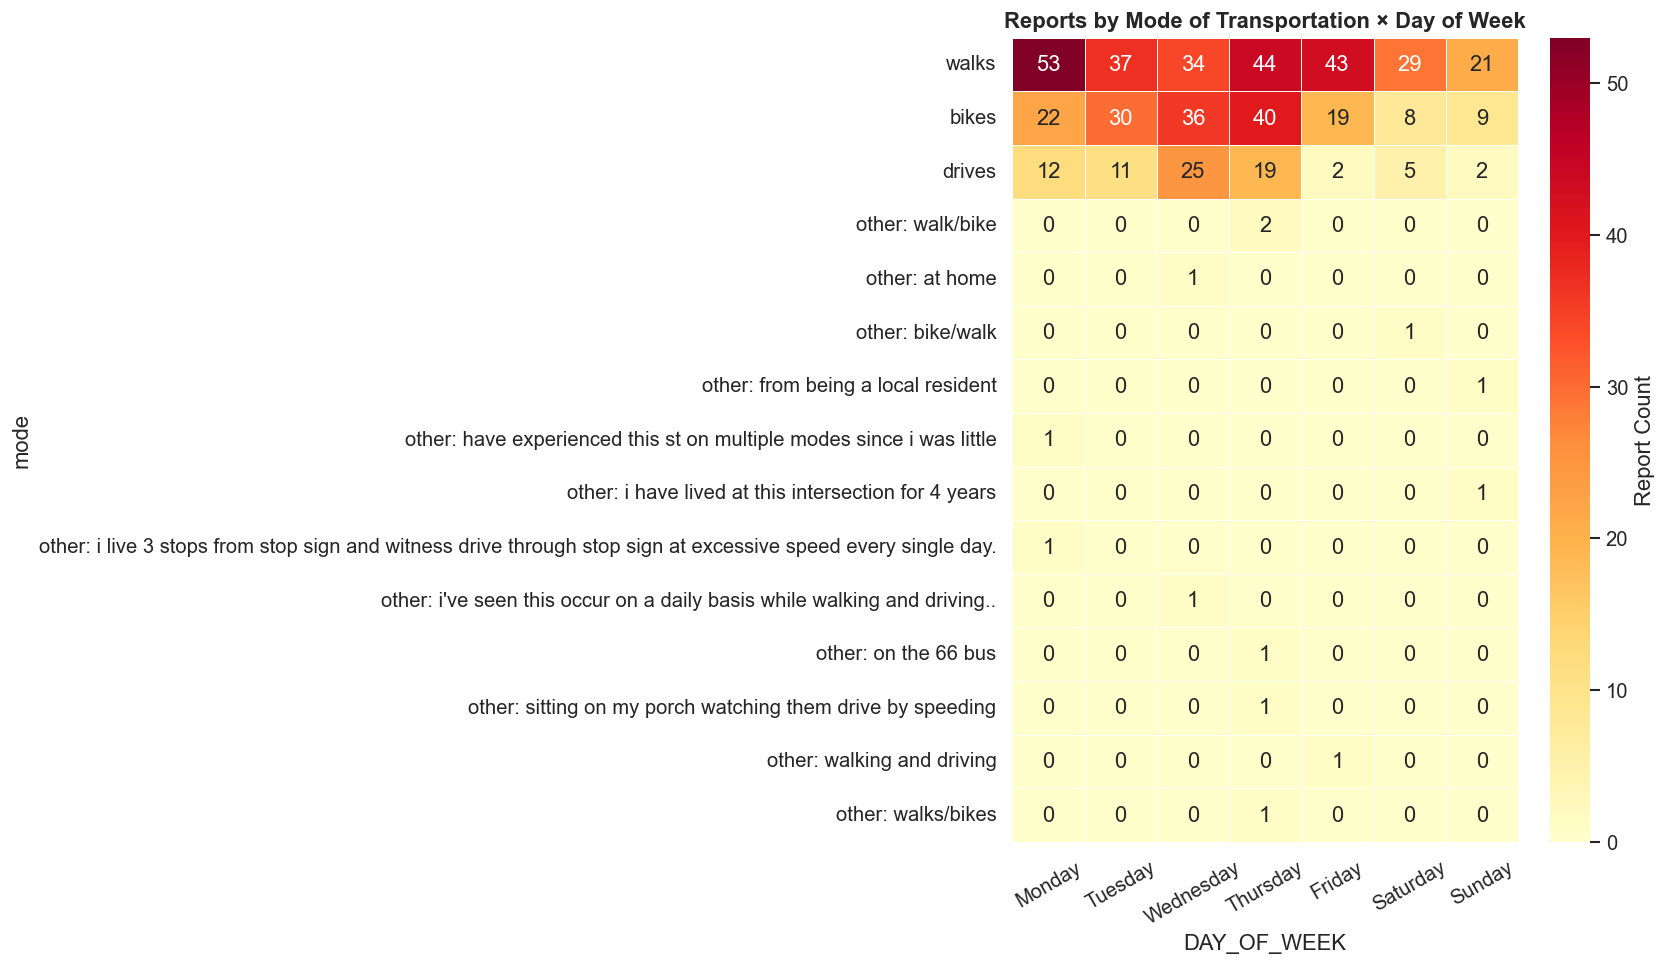

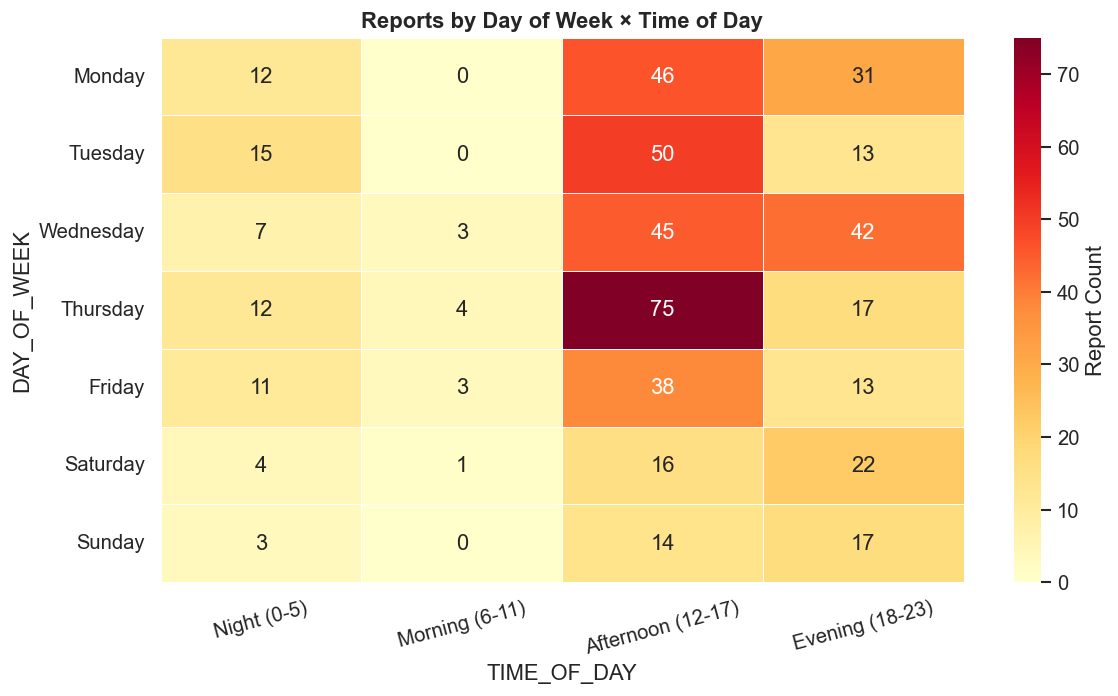

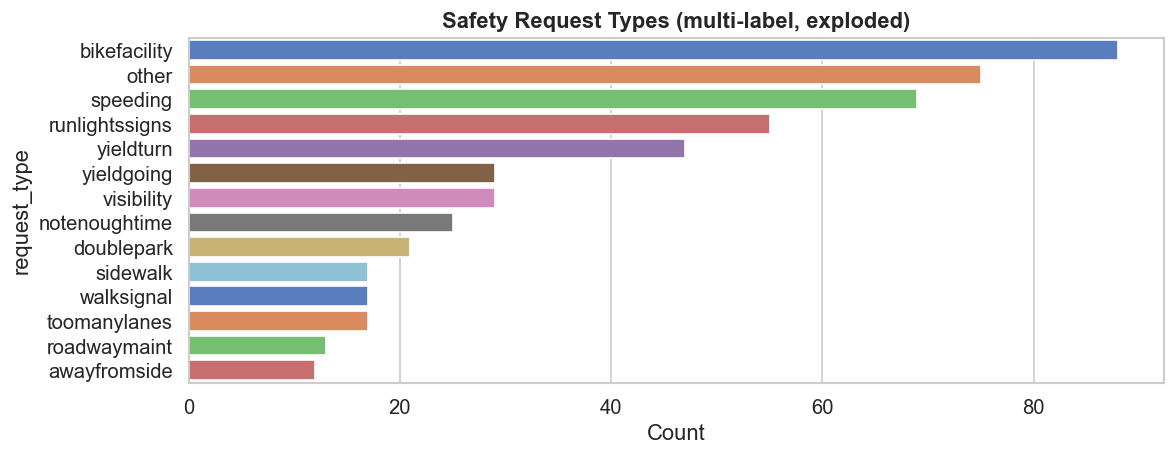

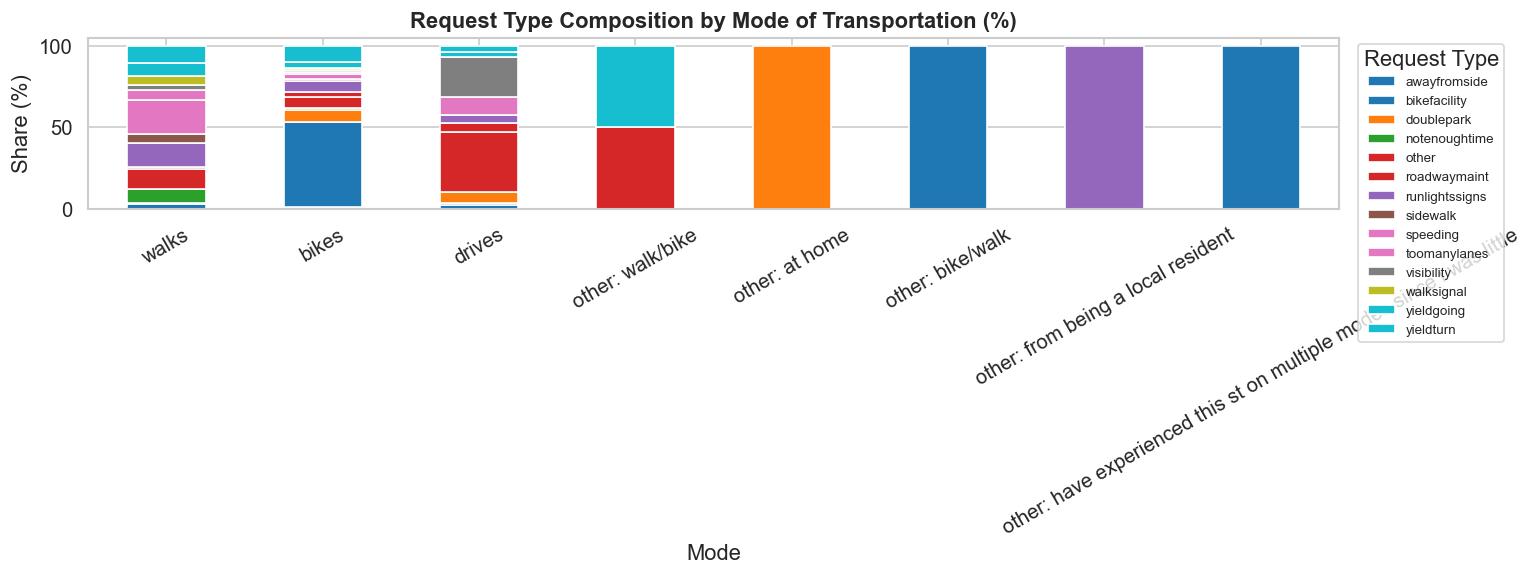

In [5]:
#### 2.2 Univariate Distributions

day_order  = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
time_order = ["Night (0-5)", "Morning (6-11)", "Afternoon (12-17)", "Evening (18-23)"]

print("=" * 55)
print(" Mode of Transportation:")
for m, c in df["mode"].value_counts(dropna=False).items():
    print(f"   {str(m):<30} {c:>6,}")

print("\n Request Types (exploded):")
for r, c in df_req["request_type"].value_counts().items():
    print(f"   {str(r):<20} {c:>6,}")

pct_vuln = df["IS_VULN"].mean() * 100
print(f"\n Vulnerable Road-User Reports (walks/bikes): {pct_vuln:.1f}%")
print("=" * 55 + "\n")

# ── Plot 1: Mode × Day of Week heatmap ───────────────────────────────────────
if "mode" in df.columns:
    pivot_mode_day = (
        df.groupby(["mode", "DAY_OF_WEEK"])
          .size()
          .unstack(fill_value=0)
          .reindex(columns=day_order)
    )
    pivot_mode_day = pivot_mode_day.loc[
        pivot_mode_day.sum(axis=1).sort_values(ascending=False).index
    ]
    fig, ax = plt.subplots(figsize=(14, max(4, len(pivot_mode_day) * 0.55)))
    sns.heatmap(pivot_mode_day, ax=ax, cmap="YlOrRd", fmt=",d", annot=True,
                linewidths=0.5, cbar_kws={"label": "Report Count"})
    ax.set_title("Reports by Mode of Transportation × Day of Week", fontweight="bold")
    ax.tick_params(axis="x", rotation=30)
    plt.tight_layout()
    plt.show()

# ── Plot 2: Day of Week × Time of Day heatmap ────────────────────────────────
pivot_day_time = (
    df.groupby(["DAY_OF_WEEK", "TIME_OF_DAY"])
      .size()
      .unstack(fill_value=0)
      .reindex(index=day_order, columns=time_order)
)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_day_time, ax=ax, cmap="YlOrRd", fmt=",d", annot=True,
            linewidths=0.5, cbar_kws={"label": "Report Count"})
ax.set_title("Reports by Day of Week × Time of Day", fontweight="bold")
ax.tick_params(axis="x", rotation=15)
plt.tight_layout()
plt.show()

# ── Plot 3: Request type distribution (exploded) ─────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
vc_req = df_req["request_type"].value_counts()
palette = sns.color_palette("muted", len(vc_req))
sns.barplot(x=vc_req.values, y=vc_req.index, ax=ax, orient="h", palette=palette)
ax.set_title("Safety Request Types (multi-label, exploded)", fontweight="bold")
ax.set_xlabel("Count")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.tight_layout()
plt.show()

# ── Plot 4: Request type by mode (stacked bar) ───────────────────────────────
pivot_req_mode = (
    df_req.groupby(["mode", "request_type"])
          .size()
          .unstack(fill_value=0)
)
pivot_req_mode = pivot_req_mode.loc[
    pivot_req_mode.sum(axis=1).sort_values(ascending=False).head(8).index
]
pivot_req_mode_pct = pivot_req_mode.div(pivot_req_mode.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(13, 5))
pivot_req_mode_pct.plot(kind="bar", stacked=True, ax=ax,
                        colormap="tab10", edgecolor="white")
ax.set_title("Request Type Composition by Mode of Transportation (%)", fontweight="bold")
ax.set_ylabel("Share (%)")
ax.set_xlabel("Mode")
ax.tick_params(axis="x", rotation=30)
ax.legend(title="Request Type", bbox_to_anchor=(1.01, 1), fontsize=8)
plt.tight_layout()
plt.show()

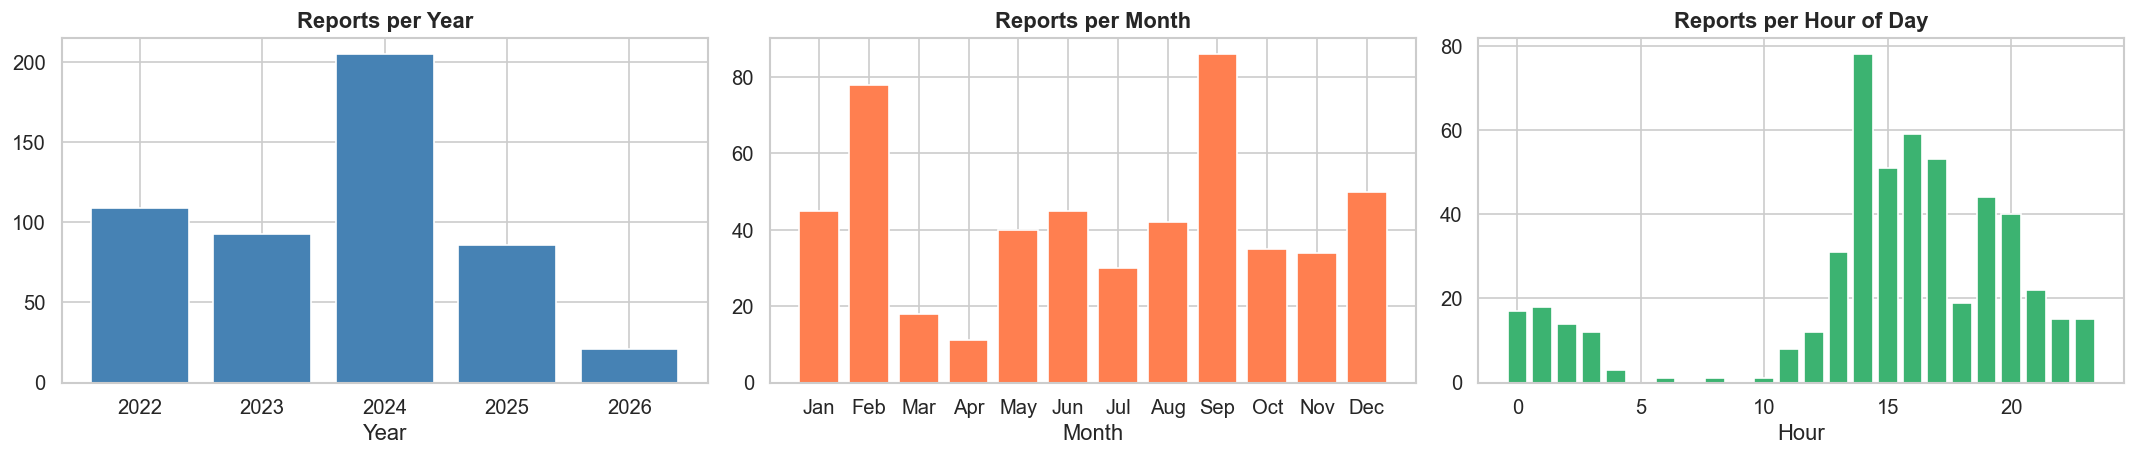

In [6]:
#  ### 2.3 Temporal Trends

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

yr = df["YEAR"].value_counts().sort_index()
axes[0].bar(yr.index.astype(int), yr.values, color="steelblue", edgecolor="white")
axes[0].set_title("Reports per Year", fontweight="bold")
axes[0].set_xlabel("Year")
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

mo = df["MONTH"].value_counts().sort_index()
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
axes[1].bar([month_labels[int(m)-1] for m in mo.index], mo.values,
            color="coral", edgecolor="white")
axes[1].set_title("Reports per Month", fontweight="bold")
axes[1].set_xlabel("Month")
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

hr = df["HOUR"].value_counts().sort_index()
axes[2].bar(hr.index.astype(int), hr.values, color="mediumseagreen", edgecolor="white")
axes[2].set_title("Reports per Hour of Day", fontweight="bold")
axes[2].set_xlabel("Hour")
axes[2].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.tight_layout()
plt.show()

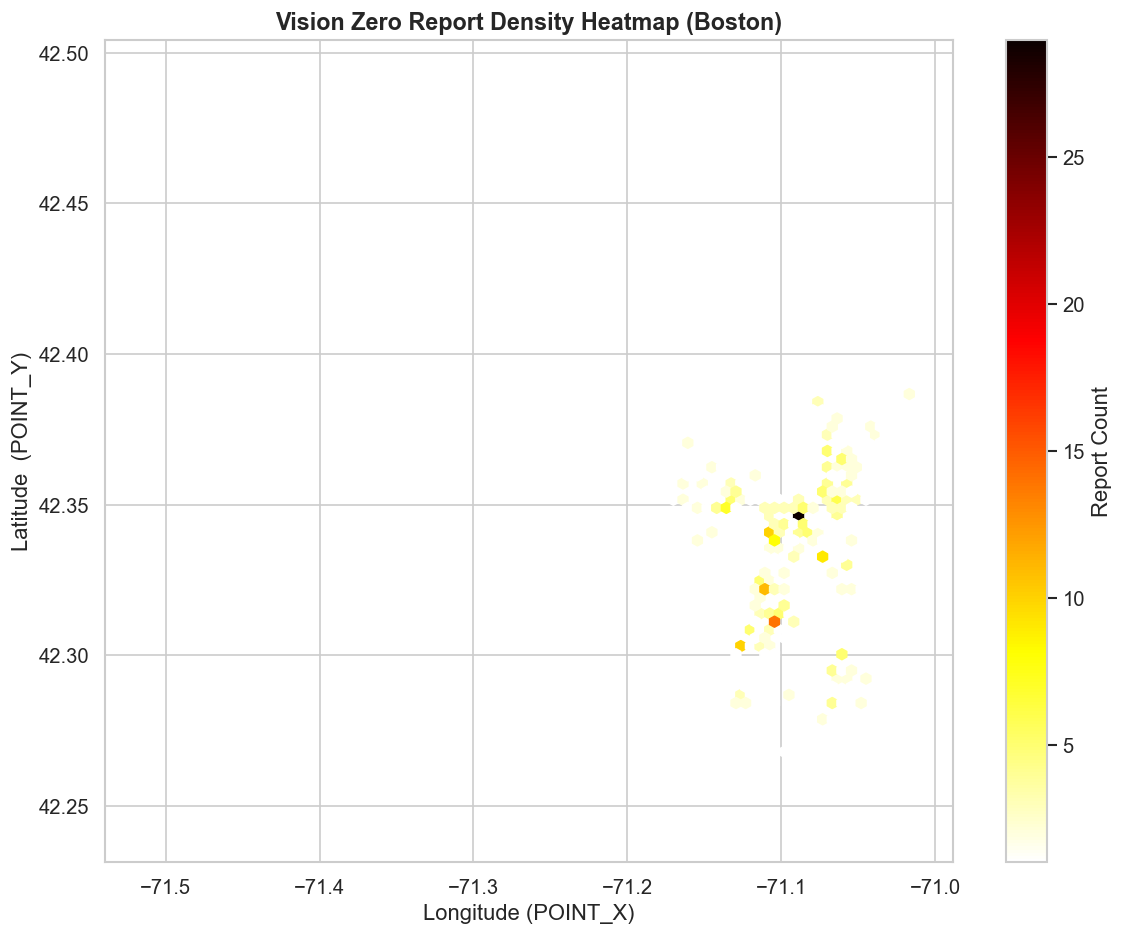

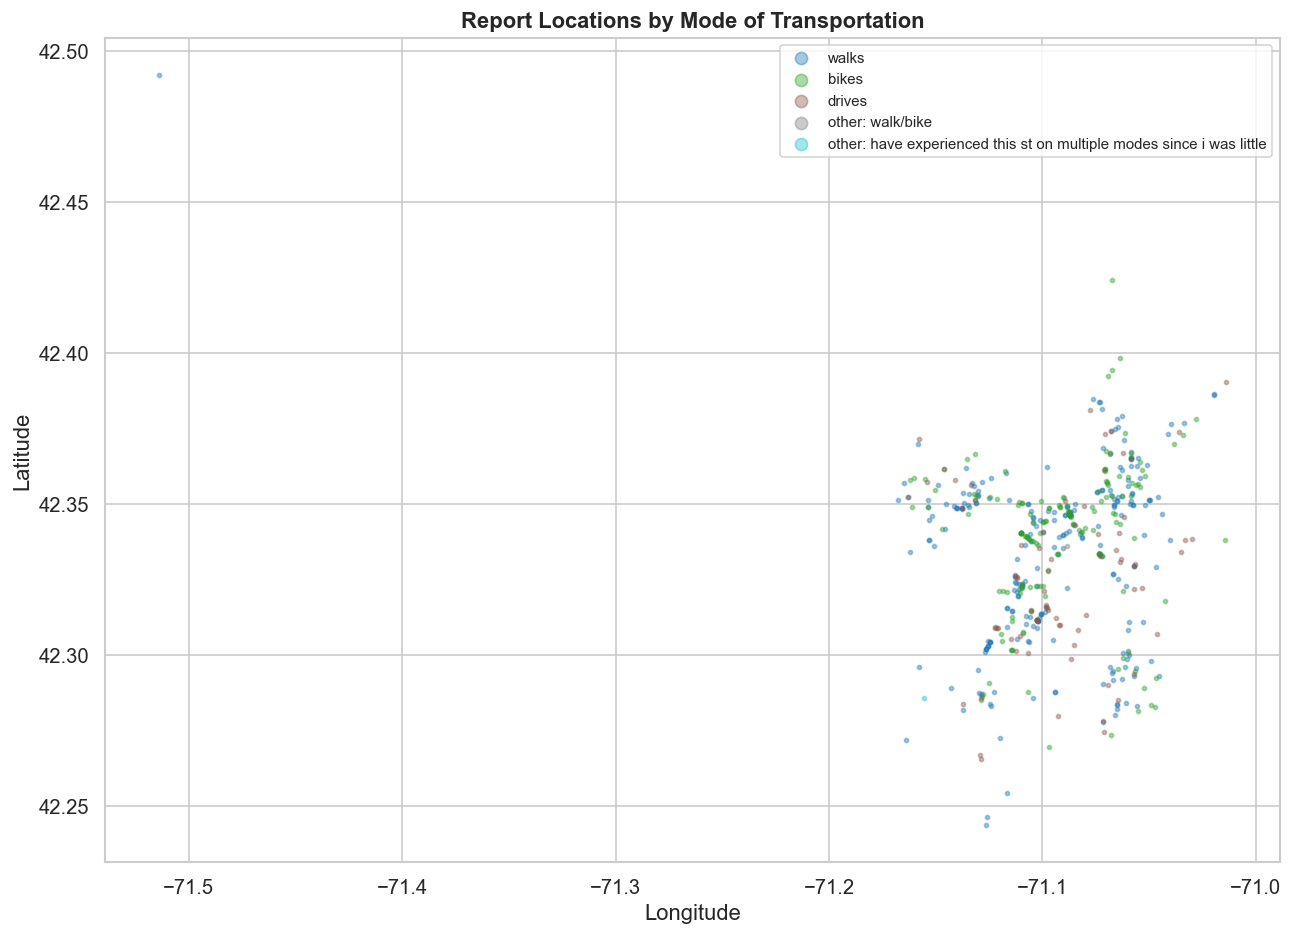

In [7]:
# ### 2.4 Geographic Distribution

geo = df.dropna(subset=["POINT_X", "POINT_Y"])
if len(geo) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    hb = ax.hexbin(geo["POINT_X"], geo["POINT_Y"], gridsize=80, cmap="hot_r", mincnt=1)
    ax.set_title("Vision Zero Report Density Heatmap (Boston)", fontweight="bold", fontsize=14)
    ax.set_xlabel("Longitude (POINT_X)")
    ax.set_ylabel("Latitude  (POINT_Y)")
    plt.colorbar(hb, ax=ax, label="Report Count")
    plt.tight_layout()
    plt.show()

    # Scatter coloured by mode
    fig, ax = plt.subplots(figsize=(11, 8))
    modes_plot = df["mode"].value_counts().dropna().head(5).index.tolist()
    cmap_modes = plt.cm.get_cmap("tab10", len(modes_plot))
    for i, m in enumerate(modes_plot):
        sub = geo[geo["mode"] == m]
        ax.scatter(sub["POINT_X"], sub["POINT_Y"], s=6, alpha=0.4,
                   color=cmap_modes(i), label=m)
    ax.set_title("Report Locations by Mode of Transportation", fontweight="bold")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(markerscale=3, fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No valid geographic coordinates found.")

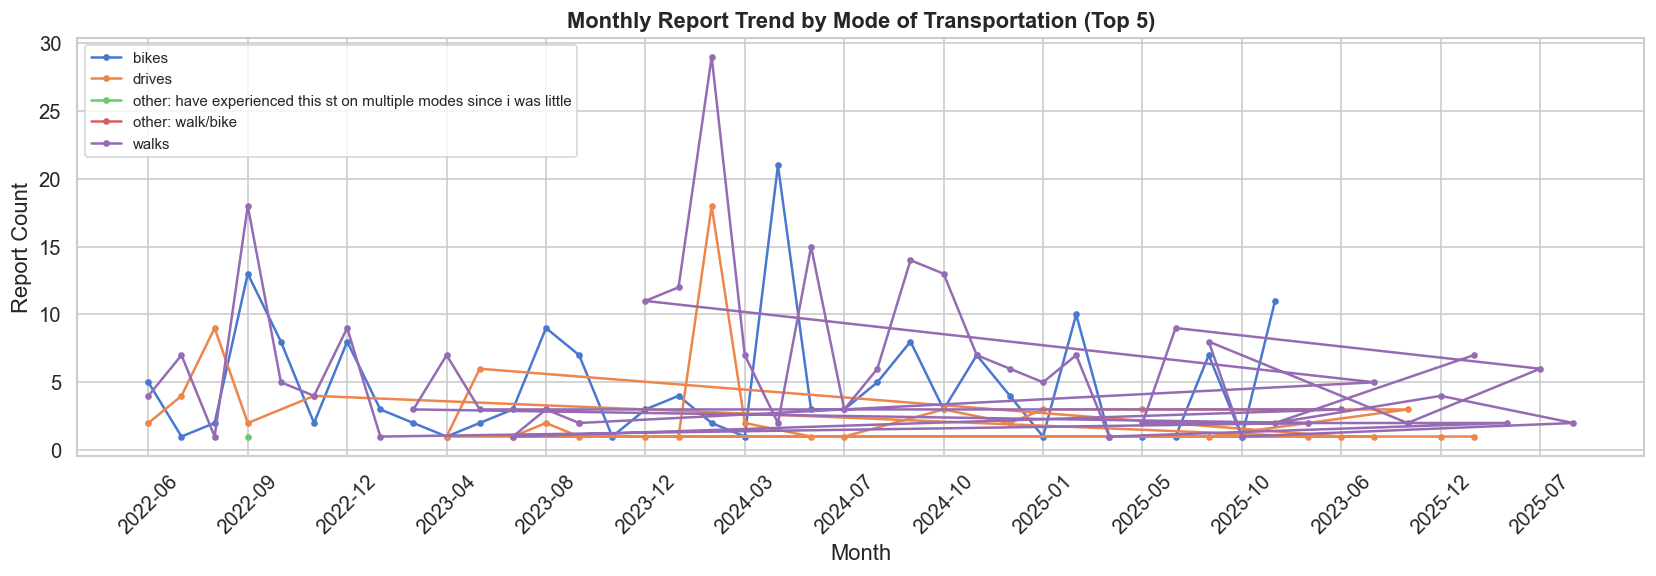

In [8]:
# ### 2.5 Monthly Trend by Mode Type

df["YM"] = df["date_and_time"].dt.to_period("M").astype(str)
trend = df.groupby(["YM", "mode"]).size().reset_index(name="count")
top_modes = df["mode"].value_counts().dropna().head(5).index.tolist()
trend_top = trend[trend["mode"].isin(top_modes)]

fig, ax = plt.subplots(figsize=(14, 5))
for mode, grp in trend_top.groupby("mode"):
    ax.plot(grp["YM"], grp["count"], marker="o", markersize=3, label=mode)
ax.set_title("Monthly Report Trend by Mode of Transportation (Top 5)", fontweight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Report Count")
ax.legend(loc="upper left", fontsize=9)
step = max(1, len(trend["YM"].unique()) // 12)
ax.set_xticks(ax.get_xticks()[::step])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 ---
 ## 3 · Data Slicing for Bias Detection

 Because Vision Zero submissions carry **no demographic identifiers** (race, income,
 age) the following structural proxies serve as slicing dimensions:

 | Dimension              | Column                          | Bias Rationale                                                  |
 |------------------------|---------------------------------|-----------------------------------------------------------------|
 | Mode of transportation | `mode`                          | Vulnerable users (walkers, cyclists) may under-report          |
 | Request type           | `request_type` (exploded)       | Some hazard types may be systematically under-flagged          |
 | Time of day            | `TIME_OF_DAY`                   | Night complaints may be suppressed (low visibility/response)    |
 | Day of week            | `DAY_OF_WEEK`                   | Weekend vs weekday reporting patterns                           |
 | Data completeness      | `POINT_X`/`POINT_Y` missing     | Spatial bias — geo-tagged reports cluster in certain areas      |

 > **Representational bias** manifests when certain modes or request types appear
 > disproportionately, potentially reflecting who feels empowered to report,
 > not just where hazards exist.

In [9]:
# ### 3.1 Slice-level Record Counts & Share

def slice_summary(df: pd.DataFrame, col: str, top_n: int = 20) -> pd.DataFrame:
    """Count, share (%), and avg missing-value rate per slice."""
    vc  = df[col].value_counts(dropna=False).head(top_n).rename("count")
    pct = (vc / len(df) * 100).rename("share_%").round(2)

    temp_col = "__slice__"
    df[temp_col] = df[col].astype(str).fillna("NaN")
    miss = (
        df.groupby(temp_col)
          .apply(lambda g: g.drop(columns=temp_col).isnull().mean().mean() * 100)
          .rename("avg_missing_%")
          .round(2)
    )
    df.drop(columns=temp_col, inplace=True)
    vc.index  = vc.index.astype(str).fillna("NaN")
    pct.index = pct.index.astype(str).fillna("NaN")
    return pd.concat([vc, pct, miss], axis=1).reindex(vc.index)


for dim in ["mode", "TIME_OF_DAY", "DAY_OF_WEEK"]:
    print(f"\n── Slice: {dim} ─────────────────────────")
    display(slice_summary(df, dim))

print("\n── Slice: request_type (exploded) ─────────────────────────")
display(slice_summary(df_req, "request_type"))


── Slice: mode ─────────────────────────


,count,share_%,avg_missing_%
mode,,,
walks,261,50.78,16.70
bikes,164,31.91,16.69
drives,76,14.79,15.52
other: walk/bike,2,0.39,10.42
other: have experienced this st on multiple modes since i was little,1,0.19,12.50
other: sitting on my porch watching them drive by speeding,1,0.19,12.50
other: walks/bikes,1,0.19,8.33
other: i've seen this occur on a daily basis while walking and driving..,1,0.19,12.50
other: bike/walk,1,0.19,12.50



── Slice: TIME_OF_DAY ─────────────────────────


,count,share_%,avg_missing_%
TIME_OF_DAY,,,
Afternoon (12-17),284,55.25,16.26
Evening (18-23),155,30.16,16.72
Night (0-5),64,12.45,16.34
Morning (6-11),11,2.14,15.15



── Slice: DAY_OF_WEEK ─────────────────────────


,count,share_%,avg_missing_%
DAY_OF_WEEK,,,
Thursday,108,21.01,15.28
Wednesday,97,18.87,16.41
Monday,89,17.32,16.81
Tuesday,78,15.18,16.88
Friday,65,12.65,16.15
Saturday,43,8.37,17.25
Sunday,34,6.61,16.91



── Slice: request_type (exploded) ─────────────────────────


,count,share_%,avg_missing_%
request_type,,,
bikefacility,88,17.12,18.49
other,75,14.59,13.88
speeding,69,13.42,18.58
runlightssigns,55,10.70,18.35
yieldturn,47,9.14,18.28
yieldgoing,29,5.64,18.65
visibility,29,5.64,18.50
notenoughtime,25,4.86,18.55
doublepark,21,4.09,18.18


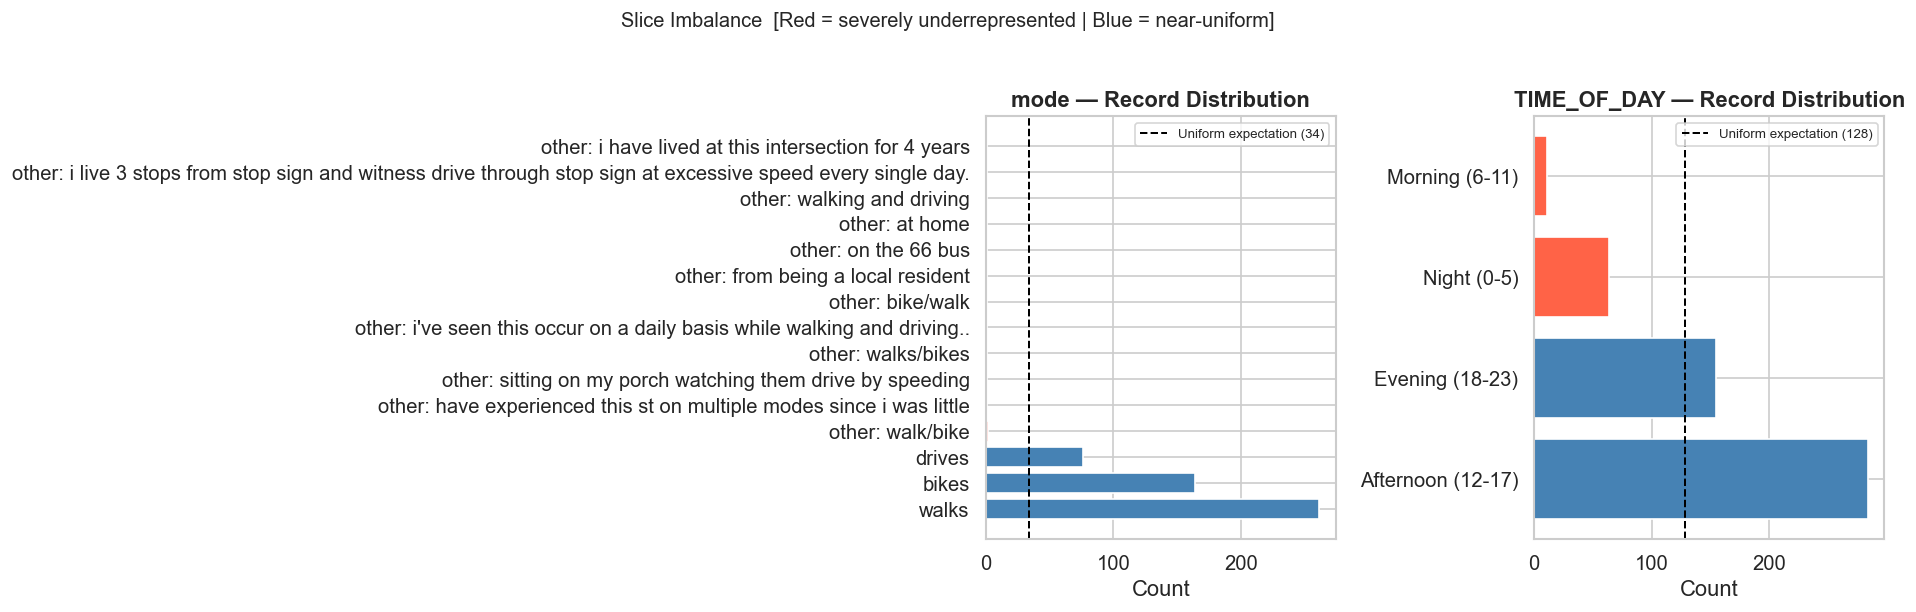

In [10]:
#  ### 3.2 Visualising Slice Imbalance

plot_dims = ["mode", "TIME_OF_DAY"]
fig, axes = plt.subplots(1, len(plot_dims), figsize=(8 * len(plot_dims), 5))

for ax, dim in zip(axes, plot_dims):
    vc       = df[dim].value_counts(dropna=False)
    expected = len(df) / len(vc)
    colors   = [
        "tomato"    if v < expected * 0.7 else
        "gold"      if v < expected * 0.9 else
        "steelblue"
        for v in vc.values
    ]
    ax.barh(vc.index.astype(str), vc.values, color=colors)
    ax.axvline(expected, color="black", linestyle="--", linewidth=1.2,
               label=f"Uniform expectation ({expected:,.0f})")
    ax.set_title(f"{dim} — Record Distribution", fontweight="bold")
    ax.set_xlabel("Count")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    ax.legend(fontsize=8)

plt.suptitle(
    "Slice Imbalance  [Red = severely underrepresented | Blue = near-uniform]",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()

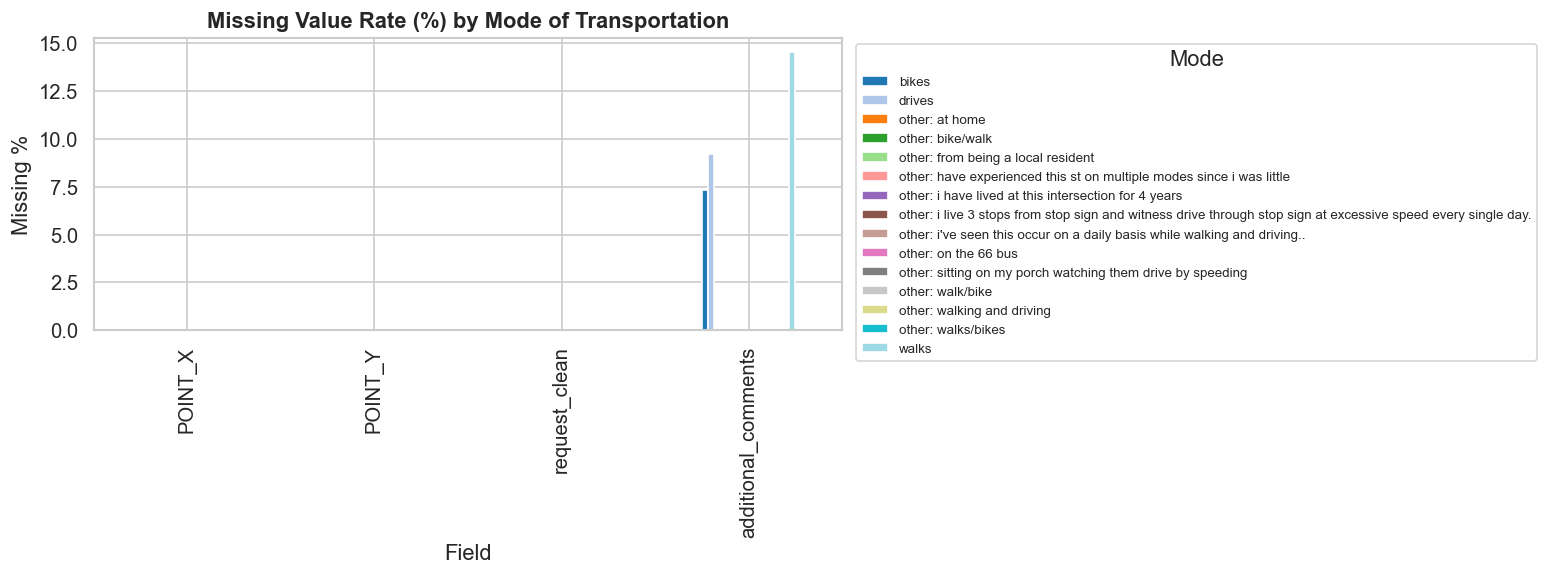

,POINT_X,POINT_Y,request_clean,additional_comments
mode,,,,
bikes,0.0,0.0,0.0,7.32
drives,0.0,0.0,0.0,9.21
other: at home,0.0,0.0,0.0,0.00
other: bike/walk,0.0,0.0,0.0,0.00
other: from being a local resident,0.0,0.0,0.0,0.00
other: have experienced this st on multiple modes since i was little,0.0,0.0,0.0,0.00
other: i have lived at this intersection for 4 years,0.0,0.0,0.0,0.00
other: i live 3 stops from stop sign and witness drive through stop sign at excessive speed every single day.,0.0,0.0,0.0,0.00
other: i've seen this occur on a daily basis while walking and driving..,0.0,0.0,0.0,0.00


In [11]:
# ### 3.3 Missing-Value Rate by Mode (Reporting Bias Proxy)
#
# A high rate of missing coordinates for a particular mode suggests those
# reporters were unable or unwilling to pinpoint the location — a form of
# **data-quality bias** that disproportionately affects some groups.

key_cols     = ["POINT_X", "POINT_Y", "request_clean", "additional_comments"]
miss_by_mode = (
    df.groupby("mode", dropna=False)[key_cols]
      .apply(lambda g: g.isnull().mean() * 100)
      .round(2)
)

fig, ax = plt.subplots(figsize=(13, 5))
miss_by_mode.T.plot(kind="bar", ax=ax, colormap="tab20", edgecolor="white")
ax.set_title("Missing Value Rate (%) by Mode of Transportation", fontweight="bold")
ax.set_ylabel("Missing %")
ax.set_xlabel("Field")
ax.legend(title="Mode", bbox_to_anchor=(1.01, 1), fontsize=8)
plt.tight_layout()
plt.show()

display(miss_by_mode)

In [12]:
 ### 3.4 Vulnerable Road-User Rate per Slice (Fairlearn MetricFrame)
#
# `IS_VULN = 1` when mode is `walks` or `bikes`.  We use a dummy
# predictor (always-1) to compute the *selection rate* per slice, which
# equals the **proportion of vulnerable-user reports** — our fairness metric.

if HAS_FAIRLEARN:
    df_fl = df.dropna(subset=["mode", "IS_VULN"]).copy()
    y_true = df_fl["IS_VULN"]
    y_pred = np.ones(len(df_fl), dtype=int)
    sf     = df_fl["mode"].astype(str)

    mf = MetricFrame(
        metrics={"selection_rate": selection_rate, "count": count},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sf,
    )
    print("MetricFrame — Vulnerable-User Rate by Mode:")
    display(mf.by_group)

    rates = mf.by_group["selection_rate"].dropna()
    di    = rates.min() / rates.max() if rates.max() > 0 else np.nan
    print(f"\nDisparate Impact Ratio (min/max): {di:.4f}  "
          f"({'⚠  Potential Bias — below 80% rule' if di < 0.8 else '✓  Within 80% rule'})")
else:
    # Manual fallback
    vuln_by_mode = (
        df.groupby("mode")["IS_VULN"]
          .agg(["mean", "count"])
          .rename(columns={"mean": "vuln_rate", "count": "n"})
          .sort_values("vuln_rate", ascending=False)
    )
    vuln_by_mode["vuln_rate"] = vuln_by_mode["vuln_rate"].round(4)
    print("Vulnerable-User Rate by Mode (Fairlearn fallback):")
    display(vuln_by_mode)

MetricFrame — Vulnerable-User Rate by Mode:


,selection_rate,count
mode,,
bikes,1.0,164.0
drives,1.0,76.0
other: at home,1.0,1.0
other: bike/walk,1.0,1.0
other: from being a local resident,1.0,1.0
other: have experienced this st on multiple modes since i was little,1.0,1.0
other: i have lived at this intersection for 4 years,1.0,1.0
other: i live 3 stops from stop sign and witness drive through stop sign at excessive speed every single day.,1.0,1.0
other: i've seen this occur on a daily basis while walking and driving..,1.0,1.0



Disparate Impact Ratio (min/max): 1.0000  (✓  Within 80% rule)


In [13]:
### 3.5 SliceFinder-style Bias Detection
#
# For each categorical slice, flag groups whose IS_VULN rate deviates more than
# `z_thresh` standard deviations from the dataset-wide mean.

def find_biased_slices(
    df: pd.DataFrame,
    slice_col: str,
    metric_col: str = "IS_VULN",
    z_thresh: float = 2.0,
) -> pd.DataFrame:
    """Flag slices with statistically unusual metric rates (SliceFinder approach)."""
    stats = (
        df.groupby(slice_col, dropna=False)[metric_col]
          .agg(["mean", "count"])
          .rename(columns={"mean": "rate", "count": "n"})
          .reset_index()
    )
    overall_mean = df[metric_col].mean()
    overall_std  = df[metric_col].std()
    stats["z_score"]     = ((stats["rate"] - overall_mean) / overall_std
                            if overall_std > 0 else 0)
    stats["flagged"]     = stats["z_score"].abs() > z_thresh
    stats["deviation_%"] = ((stats["rate"] - overall_mean) / overall_mean * 100).round(2)
    return stats.sort_values("z_score", key=abs, ascending=False)


print("── SliceFinder results: mode ──────────────────────")
display(find_biased_slices(df, "mode"))

print("\n── SliceFinder results: TIME_OF_DAY ───────────────")
display(find_biased_slices(df, "TIME_OF_DAY"))

print("\n── SliceFinder results: DAY_OF_WEEK ───────────────")
display(find_biased_slices(df, "DAY_OF_WEEK"))

── SliceFinder results: mode ──────────────────────


,mode,rate,n,z_score,flagged,deviation_%
1,drives,0.0,76,-2.183115,True,-100.00
2,other: at home,0.0,1,-2.183115,True,-100.00
3,other: bike/walk,0.0,1,-2.183115,True,-100.00
4,other: from being a local resident,0.0,1,-2.183115,True,-100.00
5,other: have experienced this st on multiple mo...,0.0,1,-2.183115,True,-100.00
6,other: i have lived at this intersection for 4...,0.0,1,-2.183115,True,-100.00
7,other: i live 3 stops from stop sign and witne...,0.0,1,-2.183115,True,-100.00
8,other: i've seen this occur on a daily basis w...,0.0,1,-2.183115,True,-100.00
9,other: on the 66 bus,0.0,1,-2.183115,True,-100.00
10,other: sitting on my porch watching them drive...,0.0,1,-2.183115,True,-100.00



── SliceFinder results: TIME_OF_DAY ───────────────


,TIME_OF_DAY,rate,n,z_score,flagged,deviation_%
1,Morning (6-11),0.727273,11,-0.262908,False,-12.04
3,Evening (18-23),0.877419,155,0.133522,False,6.12
2,Afternoon (12-17),0.799296,284,-0.072746,False,-3.33
0,Night (0-5),0.843750,64,0.044625,False,2.04



── SliceFinder results: DAY_OF_WEEK ───────────────


,DAY_OF_WEEK,rate,n,z_score,flagged,deviation_%
0,Friday,0.953846,65,0.335311,False,15.36
6,Wednesday,0.721649,97,-0.277755,False,-12.72
3,Sunday,0.882353,34,0.146548,False,6.71
4,Thursday,0.777778,108,-0.129560,False,-5.93
2,Saturday,0.860465,43,0.088758,False,4.07
5,Tuesday,0.858974,78,0.084822,False,3.89
1,Monday,0.842697,89,0.041844,False,1.92


Chi-Square Test (mode × request_type)
  χ² = 482.42   df = 182   p = 4.89e-29
  → Significant association (p < 0.05)


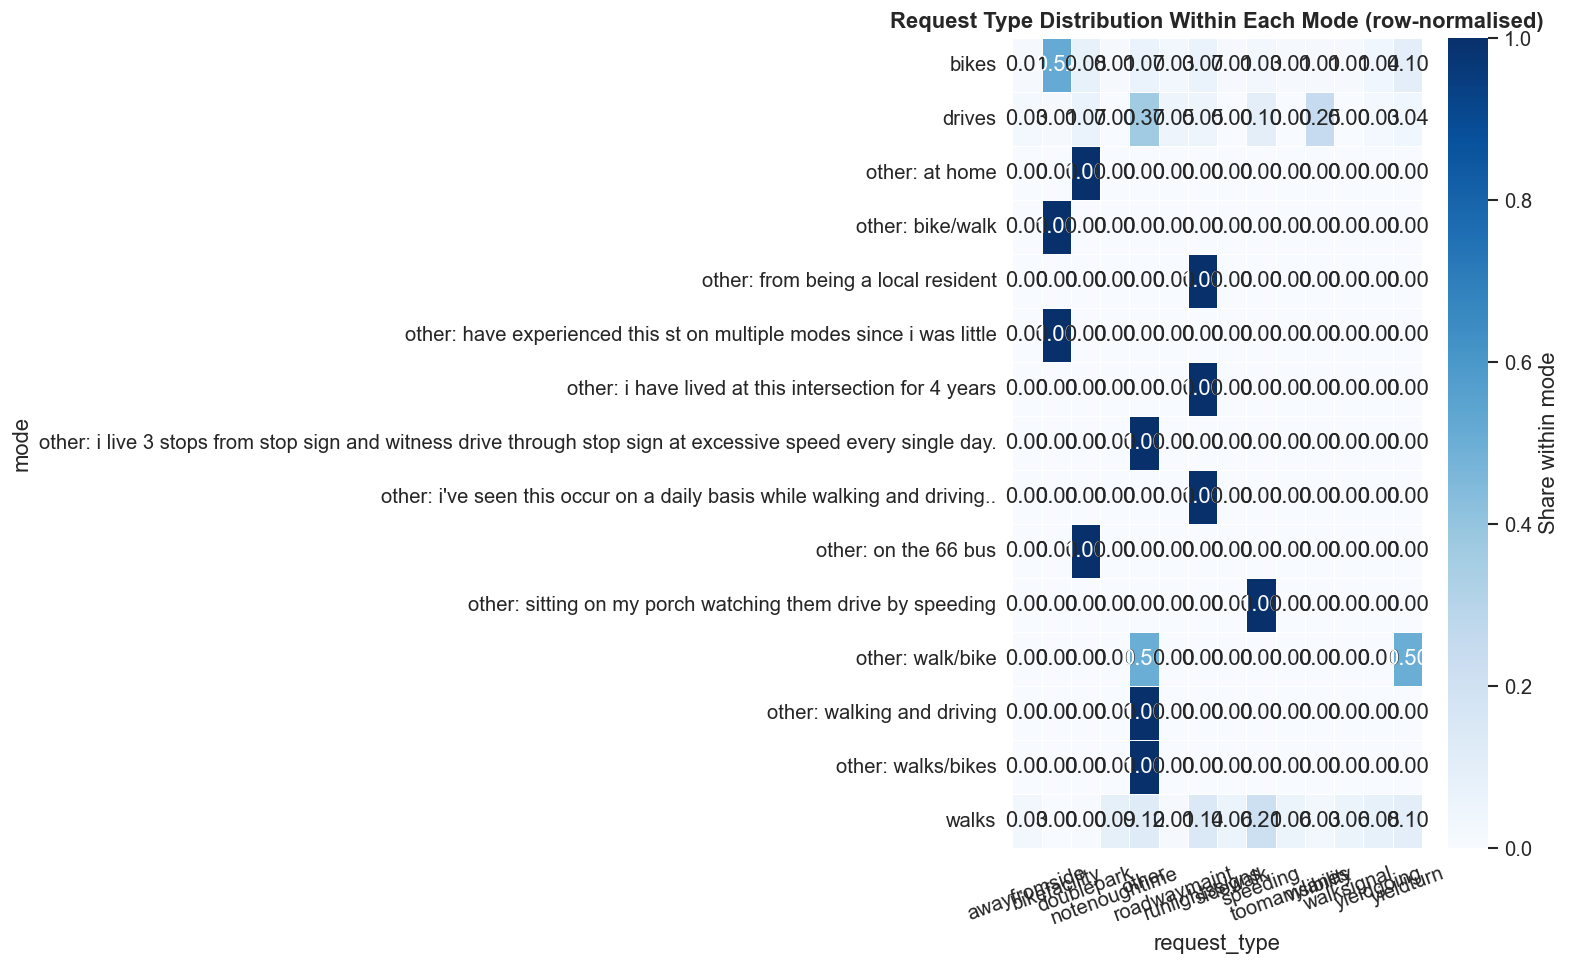

In [14]:
# ### 3.6 Cross-slice Analysis: Request Type by Mode (Chi-Square)
#
# A statistically significant association between mode and request type
# signals **interaction bias** — i.e. certain road-user types systematically
# report different hazard categories.

from scipy.stats import chi2_contingency

pivot_ct = (
    df_req.groupby(["mode", "request_type"])
          .size()
          .unstack(fill_value=0)
)
chi2, p, dof, _ = chi2_contingency(pivot_ct.values)
print(f"Chi-Square Test (mode × request_type)")
print(f"  χ² = {chi2:.2f}   df = {dof}   p = {p:.2e}")
print("  →", "Significant association (p < 0.05)" if p < 0.05
      else "No significant association")

# Visualise as normalised heatmap
pivot_norm = pivot_ct.div(pivot_ct.sum(axis=1), axis=0).round(3)
fig, ax = plt.subplots(figsize=(13, max(4, len(pivot_norm) * 0.55)))
sns.heatmap(pivot_norm, ax=ax, cmap="Blues", annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"label": "Share within mode"})
ax.set_title("Request Type Distribution Within Each Mode (row-normalised)",
             fontweight="bold")
ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
plt.show()

 ---
 ## 4 · Bias Mitigation

 ### 4.1 Oversampling Underrepresented Modes

Target (median) count per mode: 1
Resampled dataset shape: (15, 24)


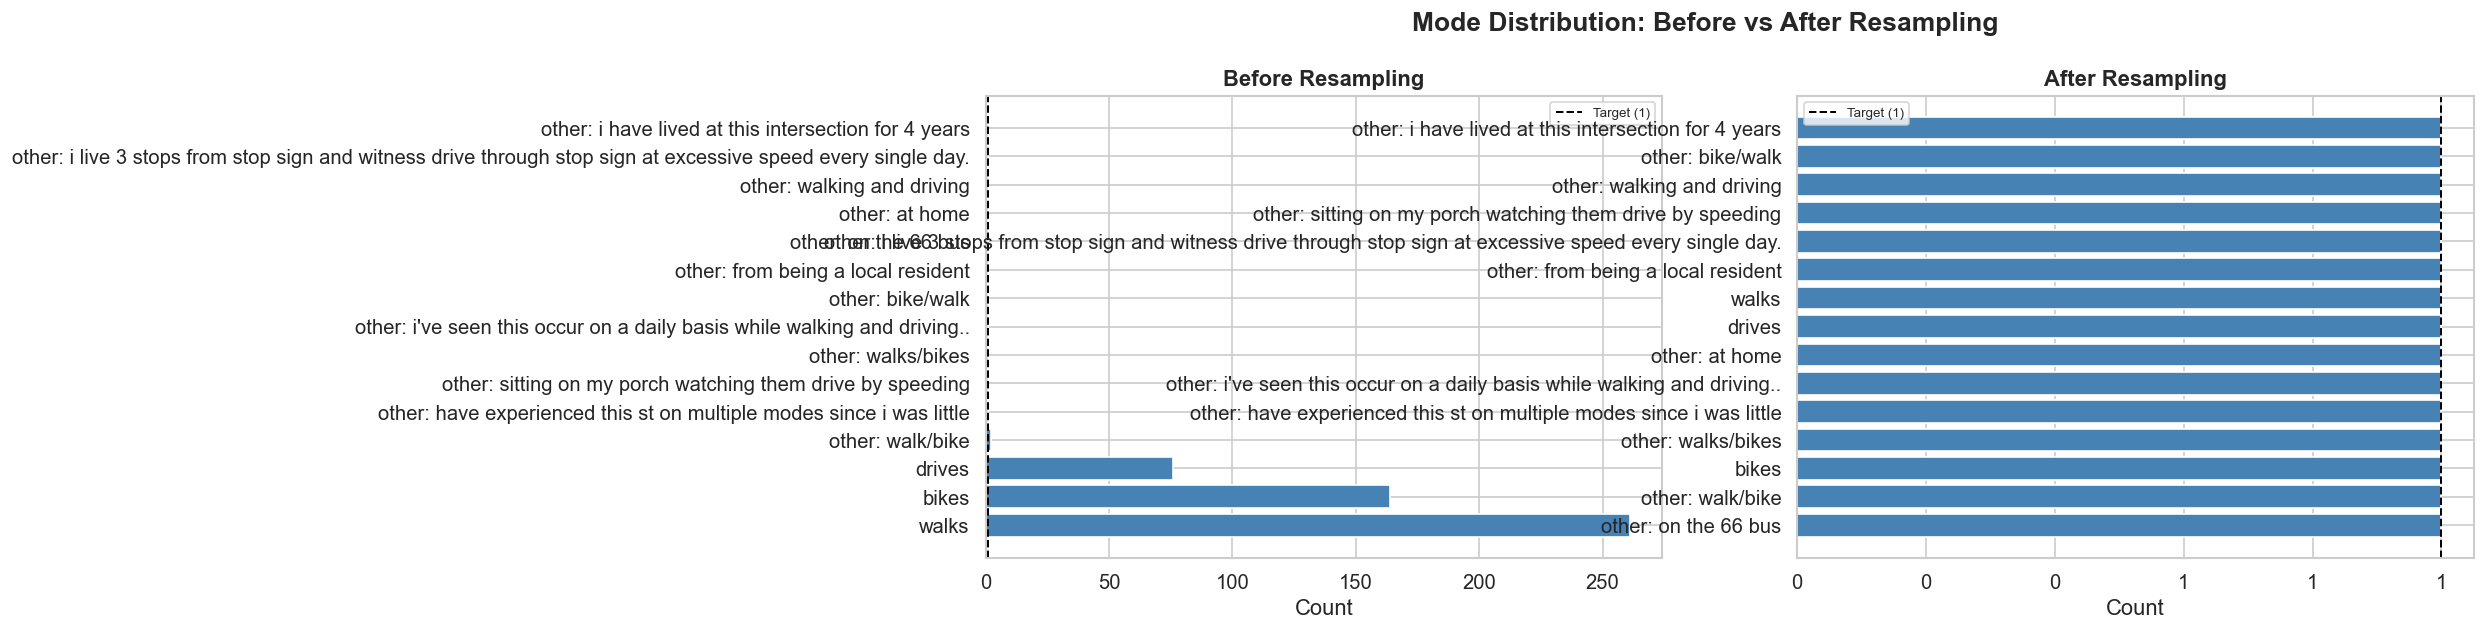

In [15]:
mode_counts = df["mode"].value_counts(dropna=True)
target      = int(mode_counts.median())
print(f"Target (median) count per mode: {target:,}")

resampled_parts = []
for mode, grp in df.groupby("mode", dropna=True):
    n = len(grp)
    if n < target:
        extra = grp.sample(target - n, replace=True, random_state=42)
        resampled_parts.append(pd.concat([grp, extra], ignore_index=True))
    else:
        resampled_parts.append(grp.sample(target, replace=False, random_state=42))

df_resampled = pd.concat(resampled_parts, ignore_index=True).sample(frac=1, random_state=42)
print(f"Resampled dataset shape: {df_resampled.shape}")

# Before / After comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for ax, data, title in [
    (axes[0], df,          "Before Resampling"),
    (axes[1], df_resampled, "After Resampling"),
]:
    vc = data["mode"].value_counts()
    ax.barh(
        vc.index.astype(str), vc.values,
        color=["tomato" if v < target * 0.8 else "steelblue" for v in vc.values]
    )
    ax.axvline(target, color="black", linestyle="--", linewidth=1.2,
               label=f"Target ({target:,})")
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Count")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    ax.legend(fontsize=8)

plt.suptitle("Mode Distribution: Before vs After Resampling", fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

Overall IS_VULN rate  : 0.8268
Flagging threshold    : 1.6537  (2× overall)

Flagged modes (0):


,vuln_rate
mode,


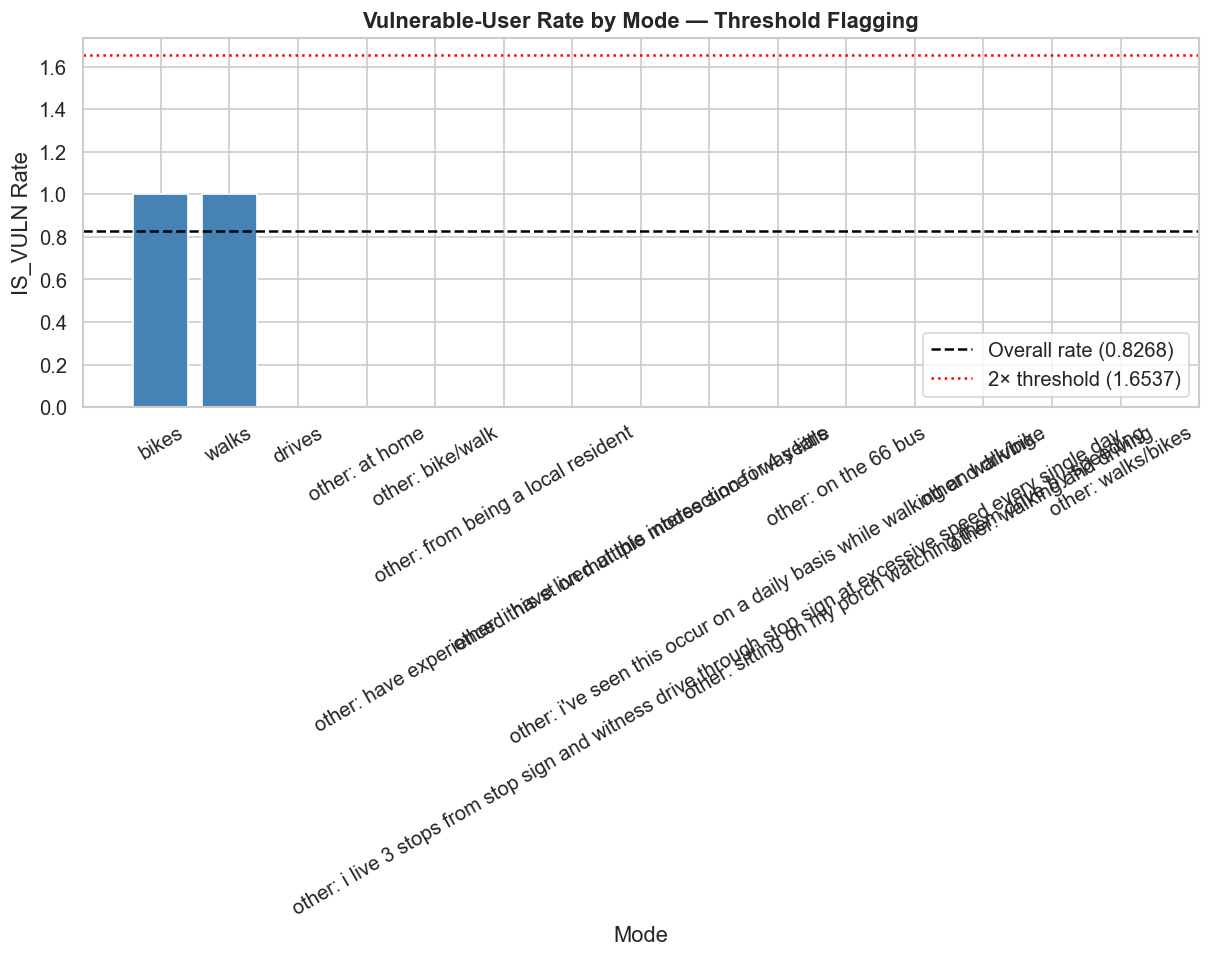

In [16]:
#  ### 4.2 Threshold-based Flagging (High Vulnerable-User Concentration)
#
# Flag modes where the proportion of vulnerable-road-user reports is ≥ 2× average,
# indicating areas needing priority investigation and potential decision-threshold
# adjustment in downstream models.

rate_by_mode  = df.groupby("mode")["IS_VULN"].mean().sort_values(ascending=False)
overall_rate  = df["IS_VULN"].mean()
threshold     = 2.0 * overall_rate

flagged = rate_by_mode[rate_by_mode >= threshold]
print(f"Overall IS_VULN rate  : {overall_rate:.4f}")
print(f"Flagging threshold    : {threshold:.4f}  (2× overall)")
print(f"\nFlagged modes ({len(flagged)}):")
display(flagged.rename("vuln_rate").to_frame())

fig, ax = plt.subplots(figsize=(12, 4))
colors = ["tomato" if r >= threshold else "steelblue" for r in rate_by_mode.values]
ax.bar(rate_by_mode.index, rate_by_mode.values, color=colors, edgecolor="white")
ax.axhline(overall_rate, color="black", linestyle="--",
           label=f"Overall rate ({overall_rate:.4f})")
ax.axhline(threshold, color="red", linestyle=":",
           label=f"2× threshold ({threshold:.4f})")
ax.set_title("Vulnerable-User Rate by Mode — Threshold Flagging", fontweight="bold")
ax.set_ylabel("IS_VULN Rate")
ax.set_xlabel("Mode")
ax.tick_params(axis="x", rotation=30)
ax.legend()
plt.tight_layout()
plt.show()